# Insurance Claim Prediction

### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

## 1. Initial Setup

In [1]:
### Import all the Python libraries you are going to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
import keras_tuner as kt
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.losses import Poisson

2025-05-23 11:34:52.042356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
### Fix random seed for reproducibility
random_seed = 43
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## 2. Poisson GLM.

### 2.1. Data load and feature calculation

In [17]:
# Read csv file
df = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',')

# Compute frequency
df['freq'] = df['ClaimNb'] / df['Exposure']

### 2.2 Descriptive Statistics

In [18]:
# Descriptive statistics
desc = df.describe(include='all').T
medians = df.median(numeric_only=True)

# Add median to the summary table
desc['median'] = medians

# Add a column with the data format (dtype) for each feature
desc['dtype'] = df.dtypes

# Show formatted table
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,median,dtype
VehPower,678007.0,NaN,NaN,NaN,6.454653,2.050902,4.0,5.0,6.0,7.0,15.0,6.00,int64
VehAge,678007.0,NaN,NaN,NaN,7.044218,5.666235,0.0,2.0,6.0,11.0,100.0,6.00,int64
DrivAge,678007.0,NaN,NaN,NaN,45.499061,14.137492,18.0,34.0,44.0,55.0,100.0,44.00,int64
BonusMalus,678007.0,NaN,NaN,NaN,59.761588,15.6367,50.0,50.0,50.0,64.0,230.0,50.00,int64
VehBrand,678007,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
VehGas,678007,2,Regular,345871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Density,678007.0,NaN,NaN,NaN,1792.430975,3958.663031,1.0,92.0,393.0,1658.0,27000.0,393.00,int64
Region,678007,22,R24,160601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Exposure,678007.0,NaN,NaN,NaN,0.528547,0.364081,0.002732,0.18,0.49,0.99,1.0,0.49,float64
ClaimNb,678007.0,NaN,NaN,NaN,0.038913,0.204752,0.0,0.0,0.0,0.0,5.0,0.00,int64


### 2.3 Exploratory visualizations

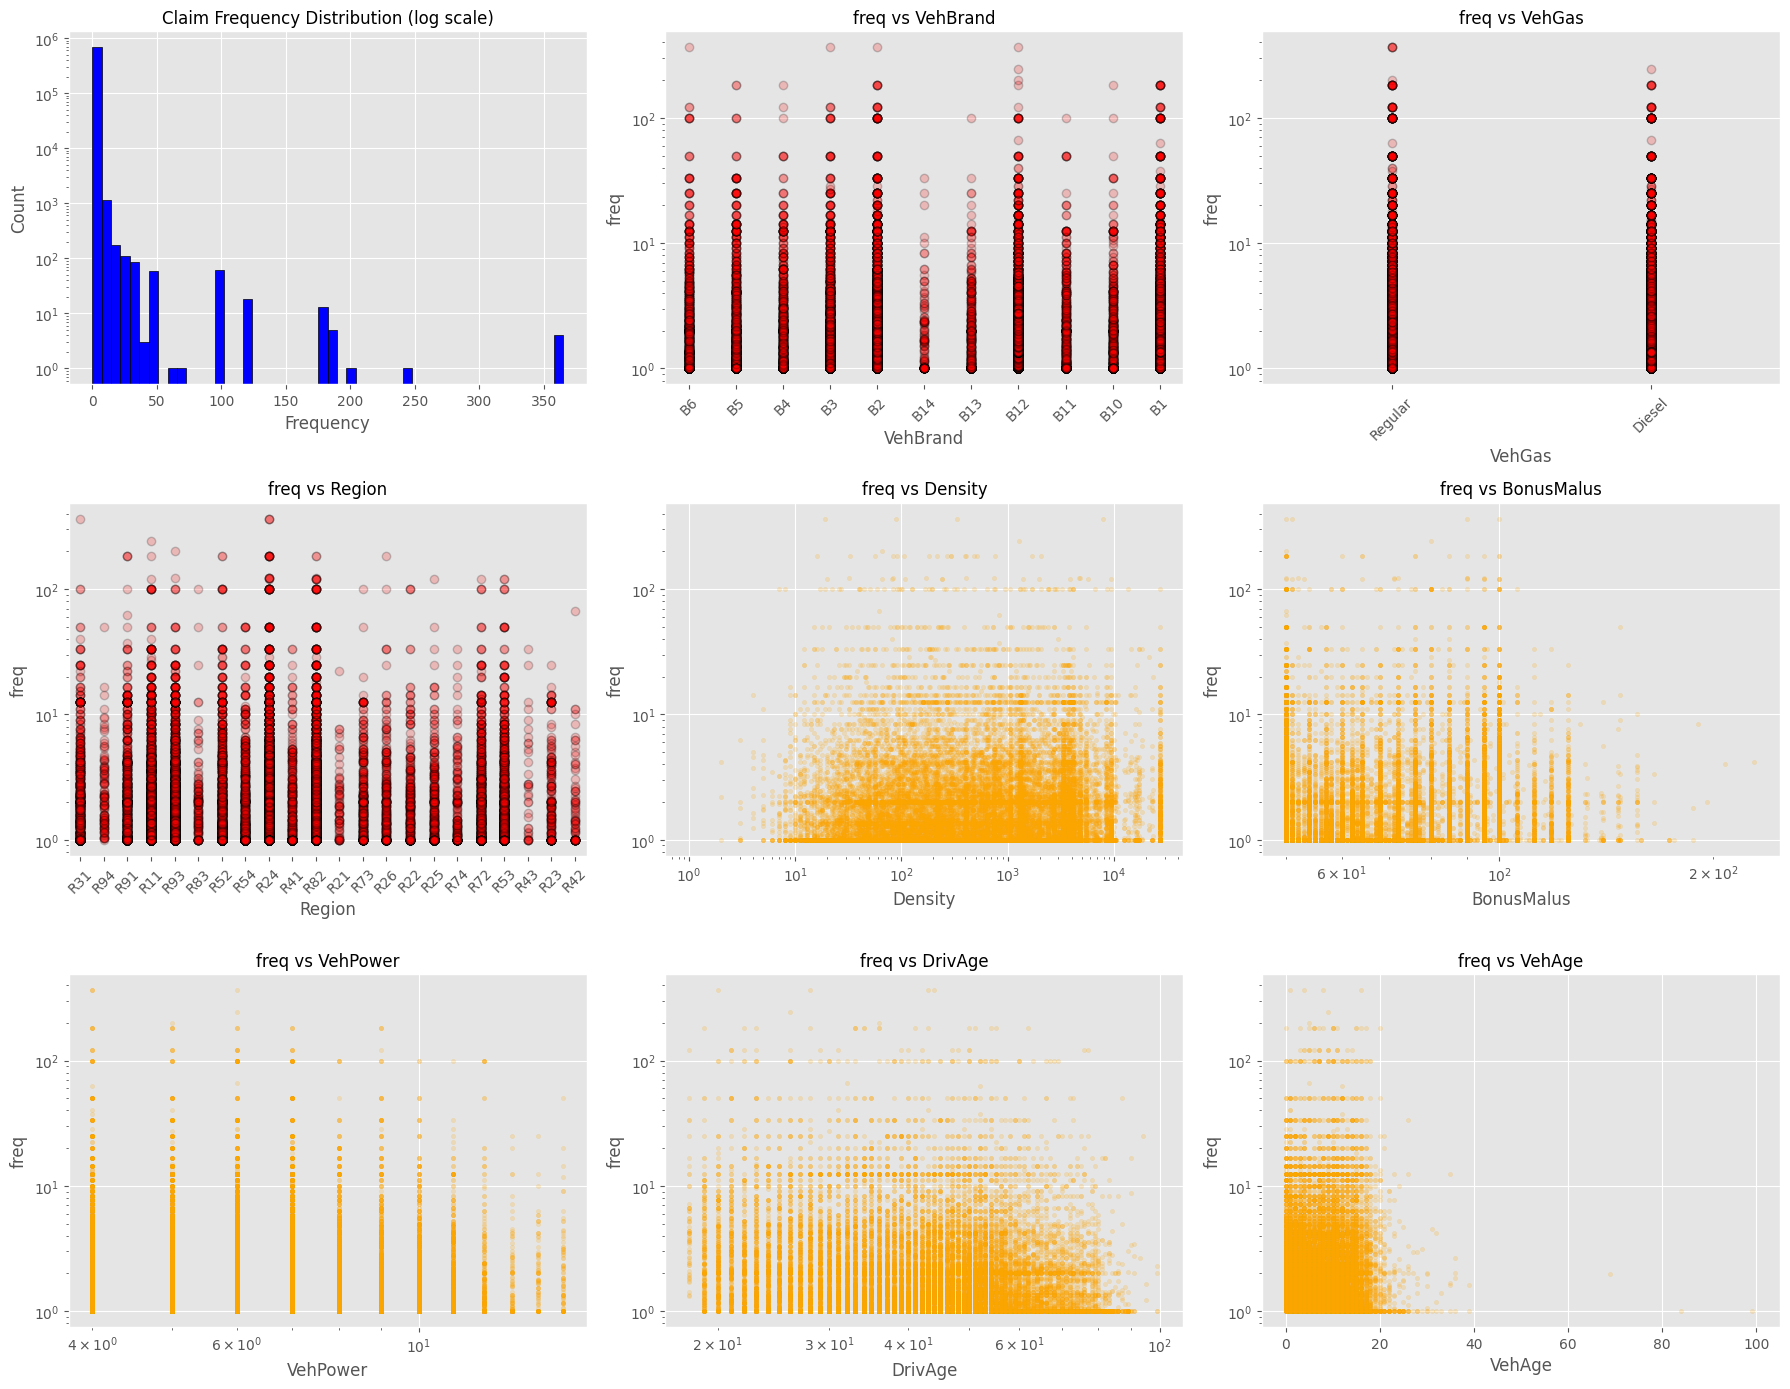

In [19]:
plt.style.use('ggplot')
color_hist = 'blue'
color_box = 'red'
color_scatter = 'orange'

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# Histogram of freq
ax = axes[0]
df['freq'].hist(bins=50, ax=ax, color=color_hist, edgecolor='black')
ax.set_yscale('log')
ax.set_title('Claim Frequency Distribution (log scale)', fontsize=12)
ax.set_xlabel('Frequency')
ax.set_ylabel('Count')

# Boxplots for categorical features
groups = ['VehBrand', 'VehGas', 'Region']
for idx, col in enumerate(groups, start=1):
    ax = axes[idx]
    sns.boxplot(x=col, y='freq', data=df, ax=ax, color=color_box,
                flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor=None, alpha = 0.2))
    ax.set_yscale('log')
    ax.set_title(f'freq vs {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.tick_params(axis='x', rotation=45)

# Scatter plots for continuous variables
conts = ['Density', 'BonusMalus', 'VehPower', 'DrivAge', 'VehAge']
for idx, col in enumerate(conts, start=4):
    ax = axes[idx]
    sns.scatterplot(x=df[col], y=df['freq'], ax=ax, color=color_scatter, alpha=0.2, edgecolor=None, s=10)
    if df[col].min() > 0:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.set_title(f'freq vs {col}', fontsize=12)

# Hide any unused subplot axes
for j in range(len(groups) + len(conts) + 1, len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
plt.show()

### 2.4 Pre-Process Features

In [20]:
# Bin VehAge
df['VehAge_bin'] = pd.cut(df['VehAge'], bins=[0,6,13,np.inf], labels=['0-5','6-12','13+'])

# Log transforms
df['ln_VehPower'] = np.log(df['VehPower'])
df['ln_DrivAge']  = np.log(df['DrivAge'])
df['ln_BM']       = np.log(df['BonusMalus'])
df['ln_Density']  = np.log(df['Density'])

# Define features and sample weights
y = df['freq']
sample_weight = df['Exposure']

numeric_features = ['ln_VehPower','ln_DrivAge','ln_BM','ln_Density']
categorical_features = ['VehBrand','VehGas','Region','VehAge_bin']

### 2.5 Train-Test Split

In [21]:
X = df[numeric_features + categorical_features]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight, test_size=0.1, random_state=random_seed
)

### 2.6 Train Poisson GLM

In [56]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

glm = Pipeline(steps=[
    ('pre', preprocessor),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm.fit(X_train, y_train, glm__sample_weight=w_train)

y_pred_train = glm.predict(X_train)
y_pred_test  = glm.predict(X_test)

### 2.7 Train Poisson GLM with Interaction Features

In [90]:
def add_interactions(X_df,df):
    df_int = X_df.copy()
    df_int['DrivAge2'] = df['DrivAge']**2
    df_int['BMxDA']    = df['BonusMalus'] * df['DrivAge']
    df_int['BMxDA2']   = df['BonusMalus'] * df_int['DrivAge2']
    return df_int

X_train_int = add_interactions(X_train,df)
X_test_int  = add_interactions(X_test,df)

numeric_int = numeric_features + ['DrivAge2','BMxDA','BMxDA2']

preprocessor_int = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_int),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

glm_int = Pipeline(steps=[
    ('pre', preprocessor_int),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm_int.fit(X_train_int, y_train, glm__sample_weight=w_train)

y_pred_int_train = glm_int.predict(X_train_int)
y_pred_int_test = glm_int.predict(X_test_int)

### 2.8 Evaluate Results

In [93]:
def weighted_mae(y, y_pred, w):
    return np.average(np.abs(y - y_pred), weights=w)

def weighted_mse(y, y_pred, w):
    return np.average((y - y_pred)**2, weights=w)

def poisson_deviance(y, y_pred, w):
    return 2*np.sum(w * (y * np.log((y + 1e-8)/y_pred) - (y - y_pred)))/ np.sum(w)

# GLM metrics
mae_train = weighted_mae(y_train, y_pred_train, w_train)
mse_train = weighted_mse(y_train, y_pred_train, w_train)
mae_test  = weighted_mae(y_test, y_pred_test, w_test)
mse_test  = weighted_mse(y_test, y_pred_test, w_test)
deviance_train = poisson_deviance(y_train, y_pred_train, w_train)
deviance_test  = poisson_deviance(y_test,  y_pred_test,  w_test)

# GLM with Interaction metrics
mae_int_train = weighted_mae(y_train, y_pred_int_train, w_train)
mse_int_train = weighted_mse(y_train, y_pred_int_train, w_train)
mae_int_test  = weighted_mae(y_test, y_pred_int_test, w_test)
mse_int_test  = weighted_mse(y_test, y_pred_int_test, w_test)
deviance_int_train = poisson_deviance(y_train, y_pred_int_train, w_train)
deviance_int_test  = poisson_deviance(y_test,  y_pred_int_test,  w_test)

# Comparison DataFrame
df_compare = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [round(mae_train, 4), round(mse_train, 4), round(deviance_train, 4)],
    'GLM Test':    [round(mae_test, 4), round(mse_test, 4), round(deviance_test, 4)],
    'GLM+Int Train': [round(mae_int_train, 4), round(mse_int_train, 4), round(deviance_int_train, 4)],
    'GLM+Int Test':  [round(mae_int_test, 4), round(mse_int_test, 4), round(deviance_int_test, 4)],
})
df_compare.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.1376,0.2332,0.4559
GLM Test,0.1395,0.2734,0.4671
GLM+Int Train,0.1375,0.2332,0.4555
GLM+Int Test,0.1394,0.2734,0.4665


## 3. Poisson feedforward neural network.

### 3.1 Define Model Architecture and Hyperparameter Tuning

In [26]:
class HyperModelTuned(kt.HyperModel):
    def __init__(self, input_shape,loss= None):
        """
        A KerasTuner HyperModel for tuning a feedforward neural network for regression/classification.

        Parameters
        ----------
        input_shape : int
            Number of input features.
        loss : str or None, optional
            Loss function to use. Allowed values: 'poisson', 'crossentropy'. If None, defaults to 'poisson'.

        Notes
        -----
        - If loss is 'poisson', uses keras.losses.Poisson().
        - If loss is 'crossentropy', uses keras.losses.BinaryCrossentropy().
        """
        self.loss = loss
        super().__init__()
        self.input_shape = input_shape    

    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_shape,)))

        # Activation function
        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu']) # **WHICH ACTIVATION FUNCTION TO USE**

        # Tune the number of layers
        for i in range(hp.Int('num_layers', 2, 4)): # number of hidden layers
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=15, max_value=25, step=5),
                activation=None, # activation function set to none to perform batch normalization
                bias_initializer='zeros',
                kernel_initializer="he_normal"))
            model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer

            # Activation function
            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU(negative_slope=0.2))

        model.add(keras.layers.Dense(1, activation='exponential'))

        hp_learning_rate = hp.Choice('learning_rate',
                                    values=[1e-2, 1e-3, 1e-4]
                                    )

        if self.loss == 'crossentropy':
            loss_fn = keras.losses.BinaryCrossentropy()
        else:
            loss_fn = keras.losses.Poisson()

        model.compile(
            loss=loss_fn,
            optimizer='Adam'
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [5000, 10000, 15000]),
            **kwargs,
        )

def tuner_build_model_cv(training_set_x, training_set_y, sample_weight, path, name, e, random_seed, input_shape, k=5, loss='crossentropy'):
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    all_val_losses = []

    # Save the best tuner from all folds
    best_tuner = None
    best_loss = float('inf')

    fold = 1
    for train_index, val_index in kfold.split(training_set_x):
        print(f"\n--- Fold {fold} ---")

        x_train, x_val = training_set_x[train_index], training_set_x[val_index]
        y_train, y_val = training_set_y[train_index], training_set_y[val_index]
        sw_train, sw_val = sample_weight[train_index], sample_weight[val_index]

        tuner = kt.RandomSearch(
            HyperModelTuned(input_shape=input_shape, loss=loss),
            objective='val_loss',
            max_trials=10,
            executions_per_trial=1,
            seed=random_seed,
            directory=path,
            project_name=f"{name}_fold{fold}"
        )

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tuner.search(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_data=(x_val, y_val, sw_val),
            callbacks=[stop_early]
        )

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hp)
        best_model.fit(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_split=0.2,
            callbacks=[stop_early]
        )

        val_loss = best_model.evaluate(x_val, y_val, sample_weight=sw_val, verbose=0)
        all_val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_tuner = tuner

        fold += 1

    print(f"\nAverage validation loss over {k} folds: {np.mean(all_val_losses)}")
    return best_tuner

### 3.2 Pre-Process Data and Initialize Hyperparameters

In [12]:
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn  = preprocessor.transform(X_test)
input_shape = X_train_nn.shape[1]
epochs = 100

### 3.3 Hyperparameter Search and Model Creation

In [27]:
tuner = tuner_build_model_cv(X_train_nn,
                             y_train.values,
                             w_train.values,
                             path='tuner',
                             name='modeling_tuned',
                             random_seed=random_seed,
                             e=epochs,
                             input_shape=input_shape,
                             k=5,
                             loss='crossentropy'
                             )

nn = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials = 1)[0])

Trial 10 Complete [00h 01m 55s]
val_loss: 0.14667117595672607

Best val_loss So Far: 0.13817299902439117
Total elapsed time: 00h 16m 13s
Epoch 1/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - loss: 0.5222 - val_loss: 0.1419
Epoch 2/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 0.1382 - val_loss: 0.1409
Epoch 3/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.1377 - val_loss: 0.1408
Epoch 4/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.1376 - val_loss: 0.1406
Epoch 5/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.1375 - val_loss: 0.1407
Epoch 6/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.1374 - val_loss: 0.1407
Epoch 7/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.1374 - val_loss: 0.1407
Epoch 8/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.1373 - val_loss: 0.1407
Epoch 9/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.1372 - val_loss: 0.1409
Epoch 10/100
12205/12205 ━━━━━━━━━━

In [28]:
# Show model architecture summary and best hyperparameters
nn.summary()

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

nn_batch_size = best_hp.get('batch_size')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 25)             │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,601 (10.16 KB)

 Non-trainable params: 170 (680.00 B)


Best hyperparameters:
activation_type: leaky_relu
num_layers: 4
units_layer_0: 25
units_layer_1: 15
learning_rate: 0.01
batch_size: 5000
units_layer_2: 25
units_layer_3: 20


### 3.4 Train Neural Network

In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=nn_batch_size,
    callbacks=[stop_early],
    validation_split=0.2,
    verbose=2
)

Epoch 1/100
98/98 - 6s - 56ms/step - loss: 1.2947 - val_loss: 0.3678
Epoch 2/100
98/98 - 2s - 17ms/step - loss: 0.2851 - val_loss: 0.2717
Epoch 3/100
98/98 - 1s - 15ms/step - loss: 0.2275 - val_loss: 0.2212
Epoch 4/100
98/98 - 1s - 15ms/step - loss: 0.1957 - val_loss: 0.1915
Epoch 5/100
98/98 - 2s - 17ms/step - loss: 0.1759 - val_loss: 0.1736
Epoch 6/100
98/98 - 2s - 17ms/step - loss: 0.1632 - val_loss: 0.1624
Epoch 7/100
98/98 - 1s - 13ms/step - loss: 0.1550 - val_loss: 0.1553
Epoch 8/100
98/98 - 1s - 15ms/step - loss: 0.1497 - val_loss: 0.1507
Epoch 9/100
98/98 - 1s - 13ms/step - loss: 0.1462 - val_loss: 0.1478
Epoch 10/100
98/98 - 1s - 14ms/step - loss: 0.1440 - val_loss: 0.1459
Epoch 11/100
98/98 - 1s - 13ms/step - loss: 0.1426 - val_loss: 0.1448
Epoch 12/100
98/98 - 1s - 13ms/step - loss: 0.1417 - val_loss: 0.1440
Epoch 13/100
98/98 - 1s - 14ms/step - loss: 0.1411 - val_loss: 0.1435
Epoch 14/100
98/98 - 1s - 14ms/step - loss: 0.1407 - val_loss: 0.1432
Epoch 15/100
98/98 - 1s - 13m

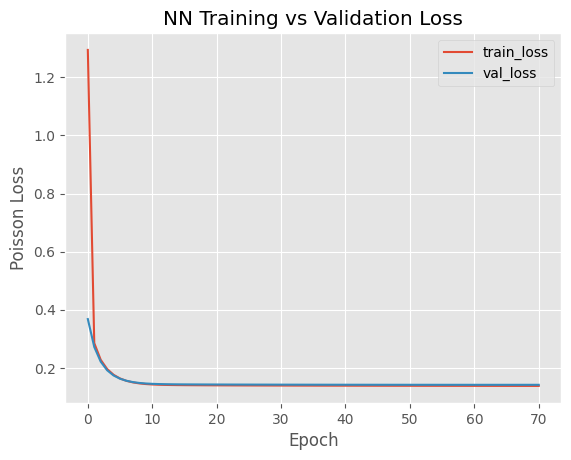

In [30]:
# Plot loss vs. epochs
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('NN Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.show()

### 3.5 Evaluate Results

In [31]:
# Neural Network Predictions
y_pred_nn_train = nn.predict(X_train_nn).flatten()
y_pred_nn_test = nn.predict(X_test_nn).flatten()

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [32]:
# Neural Network metrics
mae_nn_train = weighted_mae(y_train, y_pred_nn_train, w_train)
mse_nn_train = weighted_mse(y_train, y_pred_nn_train, w_train)
mae_nn_test  = weighted_mae(y_test, y_pred_nn_test, w_test)
mse_nn_test  = weighted_mse(y_test, y_pred_nn_test, w_test)
deviance_nn_train = poisson_deviance(y_train, y_pred_nn_train, w_train)
deviance_nn_test  = poisson_deviance(y_test,  y_pred_nn_test,  w_test)

# Comparison DataFrame
df_compare = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [mae_train, mse_train, deviance_train],
    'GLM Test':    [mae_test, mse_test, deviance_test],
    'GLM+Int Train': [mae_int_train, mse_int_train, deviance_int_train],
    'GLM+Int Test':  [mae_int_test, mse_int_test, deviance_int_test],
    'NN Train': [mae_nn_train, mse_nn_train, deviance_nn_train],
    'NN Test':  [mae_nn_test, mse_nn_test, deviance_nn_test],
})
df_compare.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.137578,0.233152,0.455879
GLM Test,0.13948,0.273447,0.467092
GLM+Int Train,0.1375,0.233144,0.455863
GLM+Int Test,0.139401,0.273442,0.4671
NN Train,0.140863,0.235084,0.475515
NN Test,0.142617,0.275373,0.488869


### 3.6 Hyperparameter Search and Model Creation (Poisson Loss)


In [33]:
tuner_poisson = tuner_build_model_cv(X_train_nn,
                                     y_train.values,
                                     w_train.values,
                                     path='tuner',
                                     name='modeling_tuned_poisson',
                                     random_seed=random_seed,
                                     e=epochs,
                                     input_shape=input_shape,
                                     k=5,
                                     loss='poisson'
                                     )

nn_poisson = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials = 1)[0])

Trial 10 Complete [00h 01m 48s]
val_loss: 0.1395801305770874

Best val_loss So Far: 0.13943061232566833
Total elapsed time: 00h 13m 25s
Epoch 1/100
Epoch 1/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.2317 - val_loss: 0.1426
Epoch 2/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.2317 - val_loss: 0.1426
Epoch 2/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.1392 - val_loss: 0.1422
Epoch 3/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.1392 - val_loss: 0.1422
Epoch 3/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.1390 - val_loss: 0.1422
Epoch 4/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.1390 - val_loss: 0.1422
Epoch 4/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.1389 - val_loss: 0.1422
Epoch 5/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.1389 - val_loss: 0.1422
Epoch 5/100
12205/12205 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.1388 - val_loss: 0.1423
Epoch 6/100
12205/12205 

In [34]:
# Show model architecture summary and best hyperparameters
nn_poisson.summary()

best_hp_poisson = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters (Poisson Loss):")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

nn_poisson_batch_size = best_hp.get('batch_size')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 25)             │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 25)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,601 (10.16 KB)

 Non-trainable params: 170 (680.00 B)


Best hyperparameters (Poisson Loss):
activation_type: leaky_relu
num_layers: 4
units_layer_0: 25
units_layer_1: 15
learning_rate: 0.01
batch_size: 5000
units_layer_2: 25
units_layer_3: 20


### 3.7 Train Neural Network (Poisson Loss)

In [35]:
stop_early_poisson = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_poisson = nn_poisson.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=epochs,
    batch_size=nn_poisson_batch_size,
    callbacks=[stop_early_poisson],
    validation_split=0.2,
    verbose=2
)

Epoch 1/100
98/98 - 5s - 52ms/step - loss: 2.1634 - val_loss: 1.1983
Epoch 2/100
98/98 - 5s - 52ms/step - loss: 2.1634 - val_loss: 1.1983
Epoch 2/100
98/98 - 2s - 15ms/step - loss: 0.5398 - val_loss: 0.3879
Epoch 3/100
98/98 - 2s - 15ms/step - loss: 0.5398 - val_loss: 0.3879
Epoch 3/100
98/98 - 2s - 15ms/step - loss: 0.2935 - val_loss: 0.2928
Epoch 4/100
98/98 - 2s - 15ms/step - loss: 0.2935 - val_loss: 0.2928
Epoch 4/100
98/98 - 2s - 15ms/step - loss: 0.2551 - val_loss: 0.2520
Epoch 5/100
98/98 - 2s - 15ms/step - loss: 0.2551 - val_loss: 0.2520
Epoch 5/100
98/98 - 2s - 16ms/step - loss: 0.2296 - val_loss: 0.2268
Epoch 6/100
98/98 - 2s - 16ms/step - loss: 0.2296 - val_loss: 0.2268
Epoch 6/100
98/98 - 2s - 16ms/step - loss: 0.2108 - val_loss: 0.2084
Epoch 7/100
98/98 - 2s - 16ms/step - loss: 0.2108 - val_loss: 0.2084
Epoch 7/100
98/98 - 2s - 17ms/step - loss: 0.1960 - val_loss: 0.1945
Epoch 8/100
98/98 - 2s - 17ms/step - loss: 0.1960 - val_loss: 0.1945
Epoch 8/100
98/98 - 2s - 18ms/step

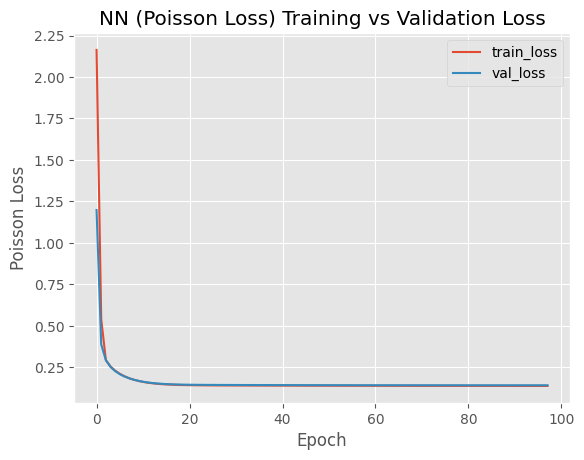

In [36]:
# Plot loss vs. epochs (Poisson Loss)
plt.figure()
plt.plot(history_poisson.history['loss'], label='train_loss')
plt.plot(history_poisson.history['val_loss'], label='val_loss')
plt.title('NN (Poisson Loss) Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.show()

### 3.8 Evaluate Results (Poisson Loss)

In [37]:
# Neural Network Predictions (Poisson Loss)
y_pred_nn_poisson_train = nn_poisson.predict(X_train_nn).flatten()
y_pred_nn_poisson_test = nn_poisson.predict(X_test_nn).flatten()

# Neural Network metrics (Poisson Loss)
mae_nn_poisson_train = weighted_mae(y_train, y_pred_nn_poisson_train, w_train)
mse_nn_poisson_train = weighted_mse(y_train, y_pred_nn_poisson_train, w_train)
mae_nn_poisson_test  = weighted_mae(y_test, y_pred_nn_poisson_test, w_test)
mse_nn_poisson_test  = weighted_mse(y_test, y_pred_nn_poisson_test, w_test)
deviance_nn_poisson_train = poisson_deviance(y_train, y_pred_nn_poisson_train, w_train)
deviance_nn_poisson_test  = poisson_deviance(y_test,  y_pred_nn_poisson_test,  w_test)

# Comparison DataFrame including Poisson NN
df_compare_poisson = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [mae_train, mse_train, deviance_train],
    'GLM Test':    [mae_test, mse_test, deviance_test],
    'GLM+Int Train': [mae_int_train, mse_int_train, deviance_int_train],
    'GLM+Int Test':  [mae_int_test, mse_int_test, deviance_int_test],
    'NN Train': [mae_nn_train, mse_nn_train, deviance_nn_train],
    'NN Test':  [mae_nn_test, mse_nn_test, deviance_nn_test],
    'NN Poisson Train': [mae_nn_poisson_train, mse_nn_poisson_train, deviance_nn_poisson_train],
    'NN Poisson Test':  [mae_nn_poisson_test, mse_nn_poisson_test, deviance_nn_poisson_test],
})
df_compare_poisson.T

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
19069/19069 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.137578,0.233152,0.455879
GLM Test,0.13948,0.273447,0.467092
GLM+Int Train,0.1375,0.233144,0.455863
GLM+Int Test,0.139401,0.273442,0.4671
NN Train,0.140863,0.235084,0.475515
NN Test,0.142617,0.275373,0.488869
NN Poisson Train,0.138112,0.235091,0.475655
NN Poisson Test,0.139801,0.275329,0.488599


### 4. Regularization Techniques: L2-Regularization (Poisson GLM)

We apply L2-regularization (Ridge) to the Poisson GLM to reduce overfitting and improve generalization. The optimal regularization parameter (`alpha`) is selected using a grid-search procedure with cross-validation.

In [39]:
from sklearn.model_selection import GridSearchCV

# Define a pipeline with preprocessing and Poisson GLM
glm_l2 = Pipeline(steps=[
    ('pre', preprocessor_int),
    ('glm', PoissonRegressor(max_iter=1000))
])

# Define grid of alpha values for L2 regularization
param_grid = {
    'glm__alpha': np.logspace(-6, 1, 16)  # from 1e-6 to 10
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(glm_l2, param_grid, cv=5, scoring='neg_mean_poisson_deviance', n_jobs=-1)
grid_search.fit(X_train_int, y_train, glm__sample_weight=w_train)

# Best alpha parameter
best_alpha = grid_search.best_params_['glm__alpha']
print(f"Best alpha (L2 regularization): {best_alpha}")

# Train final model with best alpha
glm_l2_final = grid_search.best_estimator_

# Predictions
y_pred_l2_train = glm_l2_final.predict(X_train_int)
y_pred_l2_test = glm_l2_final.predict(X_test_int)

# Evaluate metrics
mae_l2_train = weighted_mae(y_train, y_pred_l2_train, w_train)
mse_l2_train = weighted_mse(y_train, y_pred_l2_train, w_train)
deviance_l2_train = poisson_deviance(y_train, y_pred_l2_train, w_train)

mae_l2_test = weighted_mae(y_test, y_pred_l2_test, w_test)
mse_l2_test = weighted_mse(y_test, y_pred_l2_test, w_test)
deviance_l2_test = poisson_deviance(y_test, y_pred_l2_test, w_test)

# Comparison DataFrame including L2-regularized GLM
df_compare_l2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM+Int Train': [mae_int_train, mse_int_train, deviance_int_train],
    'GLM+Int Test':  [mae_int_test, mse_int_test, deviance_int_test],
    'GLM L2 Train': [mae_l2_train, mse_l2_train, deviance_l2_train],
    'GLM L2 Test':  [mae_l2_test, mse_l2_test, deviance_l2_test],
})
df_compare_l2.T

Best alpha (L2 regularization): 0.0054116952654646375


,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM+Int Train,0.1375,0.233144,0.455863
GLM+Int Test,0.139401,0.273442,0.4671
GLM L2 Train,0.137775,0.233226,0.456357
GLM L2 Test,0.139634,0.273481,0.467392


### 4.2 Regularization Techniques: L2-Regularization (Neural Network)

We apply L2-regularization to the Poisson neural network to reduce overfitting. The optimal regularization parameter (`l2`) is selected using a hyperparameter tuning procedure with cross-validation.

In [ ]:
class HyperModelTunedL2(kt.HyperModel):
    def __init__(self, input_shape, loss=None):
        self.loss = loss
        super().__init__()
        self.input_shape = input_shape    

    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_shape,)))

        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu'])
        hp_l2 = hp.Choice('l2_regularization', values=[1e-5, 1e-4, 1e-3, 1e-2])

        for i in range(hp.Int('num_layers', 2, 4)):
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=15, max_value=25, step=5),
                activation=None,
                kernel_regularizer=keras.regularizers.l2(hp_l2),
                kernel_initializer="he_normal"))
            model.add(keras.layers.BatchNormalization())

            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU(negative_slope=0.2))

        model.add(keras.layers.Dense(1, activation='exponential'))

        if self.loss == 'crossentropy':
            loss_fn = keras.losses.BinaryCrossentropy()
        else:
            loss_fn = keras.losses.Poisson()

        model.compile(loss=loss_fn, optimizer='Adam')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [5000, 10000, 15000]),
            **kwargs,
        )

# Hyperparameter tuning with L2 regularization
tuner_nn_l2 = kt.RandomSearch(
    HyperModelTunedL2(input_shape=input_shape, loss='poisson'),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    seed=random_seed,
    directory='tuner',
    project_name='nn_poisson_l2'
)

stop_early_l2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner_nn_l2.search(
    X_train_nn, y_train.values,
    sample_weight=w_train.values,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[stop_early_l2],
    verbose=2
)

# Best hyperparameters
best_hp_nn_l2 = tuner_nn_l2.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters (NN with L2):")
for k, v in best_hp_nn_l2.values.items():
    print(f"{k}: {v}")

# Build and train final model
nn_l2 = tuner_nn_l2.hypermodel.build(best_hp_nn_l2)
history_nn_l2 = nn_l2.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=epochs,
    batch_size=best_hp_nn_l2.get('batch_size'),
    callbacks=[stop_early_l2],
    validation_split=0.2,
    verbose=2
)

# Predictions and evaluation
y_pred_nn_l2_train = nn_l2.predict(X_train_nn).flatten()
y_pred_nn_l2_test = nn_l2.predict(X_test_nn).flatten()

mae_nn_l2_train = weighted_mae(y_train, y_pred_nn_l2_train, w_train)
mse_nn_l2_train = weighted_mse(y_train, y_pred_nn_l2_train, w_train)
deviance_nn_l2_train = poisson_deviance(y_train, y_pred_nn_l2_train, w_train)

mae_nn_l2_test = weighted_mae(y_test, y_pred_nn_l2_test, w_test)
mse_nn_l2_test = weighted_mse(y_test, y_pred_nn_l2_test, w_test)
deviance_nn_l2_test = poisson_deviance(y_test, y_pred_nn_l2_test, w_test)

# Comparison DataFrame including NN with L2 regularization
df_compare_nn_l2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'NN Poisson Train': [mae_nn_poisson_train, mse_nn_poisson_train, deviance_nn_poisson_train],
    'NN Poisson Test':  [mae_nn_poisson_test, mse_nn_poisson_test, deviance_nn_poisson_test],
    'NN L2 Train': [mae_nn_l2_train, mse_nn_l2_train, deviance_nn_l2_train],
    'NN L2 Test':  [mae_nn_l2_test, mse_nn_l2_test, deviance_nn_l2_test],
})
df_compare_nn_l2.T

### 4.3 Neural Network with L2-Regularization (without tuner)

We apply L2-regularization to the previously optimized Poisson neural network architecture to reduce overfitting. We use the previously found optimal hyperparameters and add L2 regularization to the Dense layers.

Epoch 1/100
98/98 - 3s - 36ms/step - loss: 0.2876 - val_loss: 0.2520
Epoch 2/100
98/98 - 3s - 36ms/step - loss: 0.2876 - val_loss: 0.2520
Epoch 2/100
98/98 - 1s - 10ms/step - loss: 0.1794 - val_loss: 0.1812
Epoch 3/100
98/98 - 1s - 10ms/step - loss: 0.1794 - val_loss: 0.1812
Epoch 3/100
98/98 - 1s - 9ms/step - loss: 0.1569 - val_loss: 0.1600
Epoch 4/100
98/98 - 1s - 9ms/step - loss: 0.1569 - val_loss: 0.1600
Epoch 4/100
98/98 - 1s - 9ms/step - loss: 0.1513 - val_loss: 0.1542
Epoch 5/100
98/98 - 1s - 9ms/step - loss: 0.1513 - val_loss: 0.1542
Epoch 5/100
98/98 - 1s - 9ms/step - loss: 0.1496 - val_loss: 0.1523
Epoch 6/100
98/98 - 1s - 9ms/step - loss: 0.1496 - val_loss: 0.1523
Epoch 6/100
98/98 - 1s - 9ms/step - loss: 0.1486 - val_loss: 0.1513
Epoch 7/100
98/98 - 1s - 9ms/step - loss: 0.1486 - val_loss: 0.1513
Epoch 7/100
98/98 - 1s - 9ms/step - loss: 0.1479 - val_loss: 0.1507
Epoch 8/100
98/98 - 1s - 9ms/step - loss: 0.1479 - val_loss: 0.1507
Epoch 8/100
98/98 - 1s - 9ms/step - loss: 0.

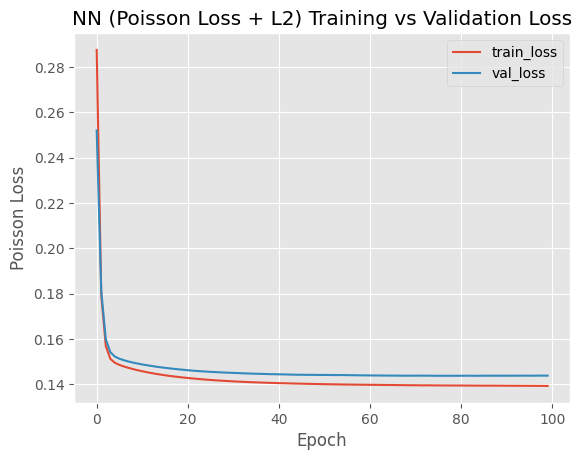

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 18s 920us/step
19069/19069 ━━━━━━━━━━━━━━━━━━━━ 18s 920us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step


,0,1,2
Metric,MAE,MSE,Poisson Deviance
NN Poisson Train,0.138112,0.235091,0.475655
NN Poisson Test,0.139801,0.275329,0.488599
NN Poisson L2 Train,0.14151,0.23491,0.4733
NN Poisson L2 Test,0.143357,0.275349,0.488313


In [41]:
# Define NN architecture with L2 regularization using previously found optimal hyperparameters
nn_poisson_l2 = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    keras.layers.Dense(20, activation=None, kernel_regularizer=keras.regularizers.l2(1e-4), kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(20, activation=None, kernel_regularizer=keras.regularizers.l2(1e-4), kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(20, activation=None, kernel_regularizer=keras.regularizers.l2(1e-4), kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(1, activation='exponential')
])

nn_poisson_l2.compile(loss=keras.losses.Poisson(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Early stopping callback
stop_early_poisson_l2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model
history_poisson_l2 = nn_poisson_l2.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=epochs,
    batch_size=nn_poisson_batch_size,
    callbacks=[stop_early_poisson_l2],
    validation_split=0.2,
    verbose=2
)

# Plot loss vs. epochs (Poisson Loss with L2)
plt.figure()
plt.plot(history_poisson_l2.history['loss'], label='train_loss')
plt.plot(history_poisson_l2.history['val_loss'], label='val_loss')
plt.title('NN (Poisson Loss + L2) Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.show()

# Predictions
y_pred_nn_poisson_l2_train = nn_poisson_l2.predict(X_train_nn).flatten()
y_pred_nn_poisson_l2_test = nn_poisson_l2.predict(X_test_nn).flatten()

# Evaluate metrics
mae_nn_poisson_l2_train = weighted_mae(y_train, y_pred_nn_poisson_l2_train, w_train)
mse_nn_poisson_l2_train = weighted_mse(y_train, y_pred_nn_poisson_l2_train, w_train)
deviance_nn_poisson_l2_train = poisson_deviance(y_train, y_pred_nn_poisson_l2_train, w_train)

mae_nn_poisson_l2_test = weighted_mae(y_test, y_pred_nn_poisson_l2_test, w_test)
mse_nn_poisson_l2_test = weighted_mse(y_test, y_pred_nn_poisson_l2_test, w_test)
deviance_nn_poisson_l2_test = poisson_deviance(y_test, y_pred_nn_poisson_l2_test, w_test)

# Comparison DataFrame including NN with L2 regularization
df_compare_nn_poisson_l2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'NN Poisson Train': [mae_nn_poisson_train, mse_nn_poisson_train, deviance_nn_poisson_train],
    'NN Poisson Test':  [mae_nn_poisson_test, mse_nn_poisson_test, deviance_nn_poisson_test],
    'NN Poisson L2 Train': [mae_nn_poisson_l2_train, mse_nn_poisson_l2_train, deviance_nn_poisson_l2_train],
    'NN Poisson L2 Test':  [mae_nn_poisson_l2_test, mse_nn_poisson_l2_test, deviance_nn_poisson_l2_test],
})
df_compare_nn_poisson_l2.T

### 4.4 Neural Network (Poisson Loss + L2) Predictions vs Actual

Visualize the predicted vs actual claim frequencies for both training and test datasets.

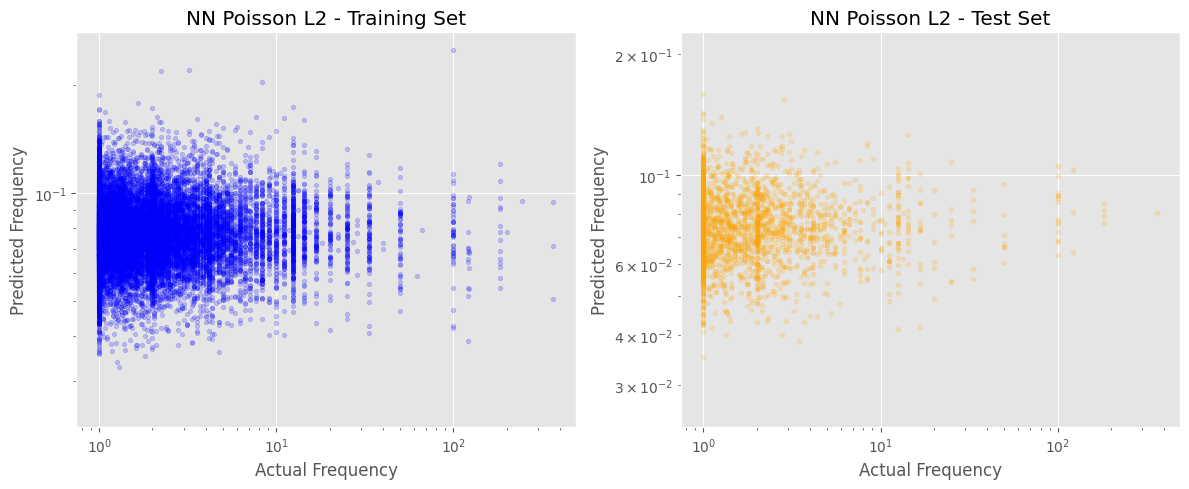

In [88]:
# Plot predicted vs actual frequencies (Training set)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_nn_poisson_l2_train, alpha=0.2, color='blue', s=10)
#plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual Frequency')
plt.ylabel('Predicted Frequency')
plt.title('NN Poisson L2 - Training Set')
plt.xscale('log')
plt.yscale('log')

# Plot predicted vs actual for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn_poisson_l2_test, alpha=0.2, color='orange', s=10)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Frequency')
plt.ylabel('Predicted Frequency')
plt.title('NN Poisson L2 - Test Set')
plt.xscale('log')
plt.yscale('log')


plt.tight_layout()
plt.show()

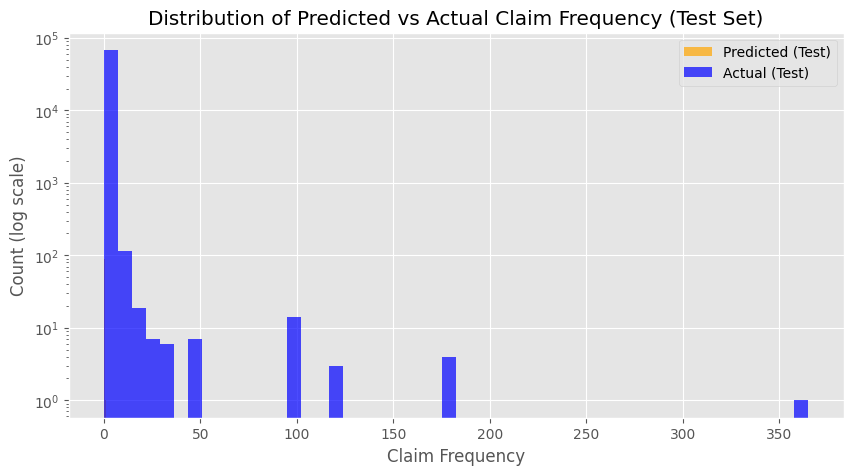

In [83]:
# To compare distributions, plot histograms of both y_pred_nn_poisson_l2_test and y_train (or y_test) separately.

plt.figure(figsize=(10,5))
plt.hist(y_pred_int_test, bins=50, alpha=0.7, label='Predicted (Test)', color='orange')
plt.hist(y_test , bins=50, alpha=0.7, label='Actual (Test)', color='blue')
plt.yscale('log')
plt.xlabel('Claim Frequency')
plt.ylabel('Count (log scale)')
plt.title('Distribution of Predicted vs Actual Claim Frequency (Test Set)')
plt.legend()
plt.show()

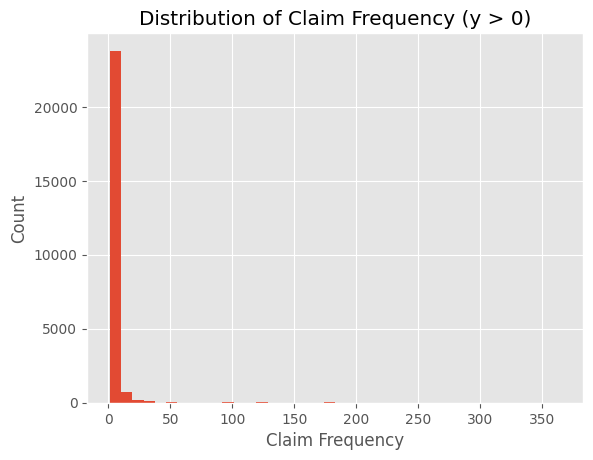

In [60]:
plt.hist(y[y > 0],bins=40)
plt.xlabel('Claim Frequency')
plt.ylabel('Count')
plt.title('Distribution of Claim Frequency (y > 0)')
plt.show()

In [ ]:
df['Exposure'].to_clipboard()

0         0.760000
1         0.740000
2         0.110000
3         0.830000
4         0.690000
            ...   
678002    0.120000
678003    0.060000
678004    0.060000
678005    0.060000
678006    0.005479
Name: Exposure, Length: 678007, dtype: float64

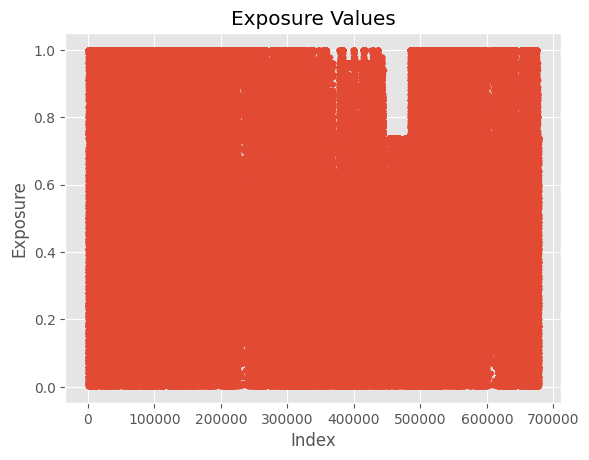

In [86]:
plt.plot(df['Exposure'], '.')
plt.xlabel('Index')
plt.ylabel('Exposure')
plt.title('Exposure Values')
plt.show()